In [ ]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

array([ 0.97737952,  1.78033768,  2.89777681,  4.47740101,  5.53098745,
        7.70714423,  7.89937853,  8.09108837, 11.64454745, 13.17905047,
       18.67490371, 19.01376507, 19.92021688, 19.92021688, 21.30531131,
       21.99992978, 21.99992978, 22.6519727 , 22.6519727 , 23.73055765,
       24.03360102, 25.45278041, 26.85562543, 27.31970705, 27.52662866,
       27.66464216, 27.87379866, 29.69243129, 29.69243129, 31.63244417,
       32.24846356, 33.14789763, 34.19961511, 35.43175811, 38.6323748 ,
       39.01044037, 39.12418218, 39.12418218, 41.53123087, 41.53123087,
       42.03531621, 43.93508586, 43.93508586, 44.03238629, 44.04012763,
       45.80161291, 45.80161291, 47.22627322, 47.22627322, 47.30376684,
       49.64821894, 49.64821894, 52.24016877, 54.2899751 , 55.45445264,
       59.09571156, 61.50539732, 63.92721411, 64.02788162, 65.79801963])

In [87]:
rb = load("/home/mmccraw/dev/data/09-09-25/rigid-bumpy/test_dynamics-2", location=["init", "final"], load_trajectory=True, load_full=True)

In [118]:
import h5py
with h5py.File('/home/mmccraw/dev/data/09-09-25/rigid-bumpy/test_dynamics-2/trajectory.h5', 'r') as f:
    print(f['ragged'].keys())
    a = f['ragged']['pair_vertex_contacts']['step_74'][()]
    print(f['contacts'][()])

<KeysViewHDF5 ['friction_coeff', 'pair_ids', 'pair_vertex_contacts']>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 1 0]
 [0 1 0 ... 1 1 0]
 [0 1 0 ... 1 1 0]]


(array([[3.848e+03, 2.870e+03, 2.262e+03, 1.004e+03, 2.980e+02, 1.190e+02,
         5.500e+01, 2.100e+01, 1.300e+01, 2.000e+00],
        [3.848e+03, 2.870e+03, 2.262e+03, 1.004e+03, 2.980e+02, 1.190e+02,
         5.500e+01, 2.100e+01, 1.300e+01, 2.000e+00]]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 2 BarContainer objects>)

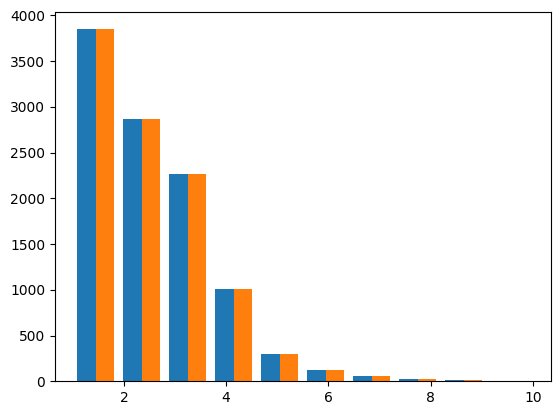

In [124]:
plt.hist(a[np.all(a > 0, axis=-1)])

In [64]:
plt.plot((rb.trajectory.pe_total + rb.trajectory.ke_total)[:, 1])

AttributeError: 'Trajectory' object has no attribute 'pe_total'

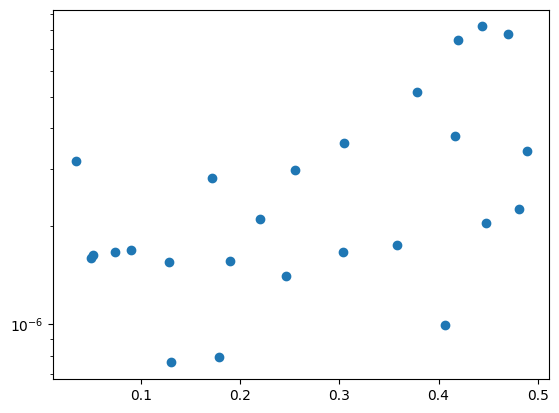

In [47]:
fluc = np.std(rb.trajectory.pe_total + rb.trajectory.ke_total, axis=0) / np.mean(rb.trajectory.pe_total + rb.trajectory.ke_total, axis=0)

plt.scatter(rb.vertex_rad[rb.vertex_system_offset[:-1]], fluc)
plt.yscale('log')

In [55]:
path = "/home/mmccraw/dev/data/09-09-25/rigid-bumpy/test_dynamics-2"
shear_modulus_path = path + '_shear_modulus.npz'
msd_path = path + '_msd.npz'
data = load(path, location=['init', 'final'], load_trajectory=True, load_full=False)
P = np.mean([data.trajectory[i].pressure for i in range(data.trajectory.num_frames())], axis=0)
if not os.path.exists(shear_modulus_path):
    temp = np.mean([data.trajectory[i].temperature for i in range(data.trajectory.num_frames())], axis=0)
    area = np.prod(data.box_size, axis=-1)
    mean_stress = np.mean([
        (data.trajectory[i].stress_tensor_total_x[:, 1] + data.trajectory[i].stress_tensor_total_y[:, 0]) / 2.0
        for i in range(data.trajectory.num_frames())
    ], axis=0)
    shear_modulus, t = compute_shear_modulus(data, save_path=shear_modulus_path, mean_stress=mean_stress)
    shear_modulus = np.mean(shear_modulus * area / temp, axis=-1)
else:
    shear_modulus = np.load(shear_modulus_path)['shear_modulus']
    t = np.load(shear_modulus_path)['t']
if not os.path.exists(msd_path):
    msd, t = compute_msd(data, save_path=msd_path)
else:
    msd = np.load(msd_path)['msd']
    t = np.load(msd_path)['t']

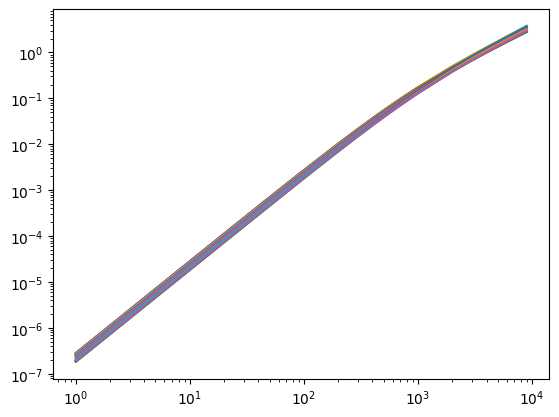

In [62]:
for i in range(msd.shape[1]):
    plt.plot(t, msd[:, i])
plt.xscale('log')
plt.yscale('log')

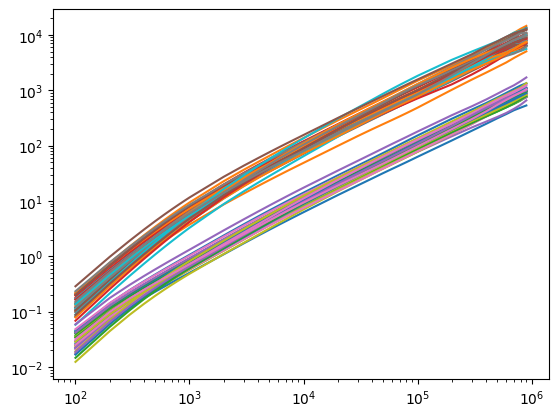

In [124]:
data_root = "/home/mmccraw/dev/data/09-09-25/new-initializations"
max_packing_fraction = 0
target_fname = None
for fname in os.listdir(data_root):
    if 'dynamics_' not in fname or os.path.isfile(os.path.join(data_root, fname)):
        continue
    data_path = os.path.join(data_root, fname)
    msd_path = data_path + '_msd.npz'
    shear_modulus_path = data_path + '_shear_modulus.npz'
    data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=False)
    msd = np.load(msd_path)
    shear_modulus = np.load(shear_modulus_path)
    i = 4
    plt.plot(msd['t'], msd['msd'][:, i, 0])
    plt.plot(msd['t'], msd['msd'][:, i, 1])
    if max(data.packing_fraction) > max_packing_fraction:
        max_packing_fraction = max(data.packing_fraction)
        target_fname = data_path
plt.yscale('log')
plt.xscale('log')

100%|██████████| 163/163 [00:02<00:00, 75.08it/s]


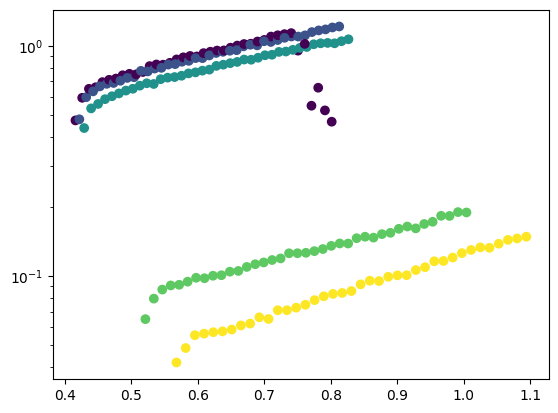

In [122]:
for fname in tqdm(os.listdir(data_root)):
    if 'dynamics_' not in fname or os.path.isfile(os.path.join(data_root, fname)):
        continue
    data_path = os.path.join(data_root, fname)
    data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=True)
    norm = plt.Normalize(data.system_id.min(), data.system_id.max())
    colors = plt.cm.viridis(norm(np.unique(data.system_id)))
    plt.scatter(data.effective_packing_fraction(), -np.mean(data.trajectory.pressure, axis=0), c=colors)
plt.yscale('log')

In [127]:
data = load(target_fname, location=['init', 'final'], load_trajectory=True, load_full=True)

In [86]:
desired_frames = 1000
steps_to_animate = downsample(data, desired_frames)

# Define the output path
output_path = "test.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=data,
    system_id=2,
    use_pbc=True,
    which='particle',
    cmap_name='viridis'
)

Creating animation:   0%|          | 5/1000 [00:00<00:22, 43.32it/s]

Saving animation to test.gif...


Creating animation: 1001it [00:58, 17.06it/s] [00:35<00:00, 30.00it/s]

Animation saved successfully!


In [73]:
data.calculate_mu_eff()  # why does this become nan?
data.n_vertices()
data.effective_packing_fraction()

array([0.80129495, 0.8126162 , 0.8265442 , 1.00398848, 1.09410815])

In [78]:
np.mean(data.trajectory.pressure, axis=0)

array([-0.46743824, -1.21202132, -1.06639396, -0.18855595, -0.14793108])

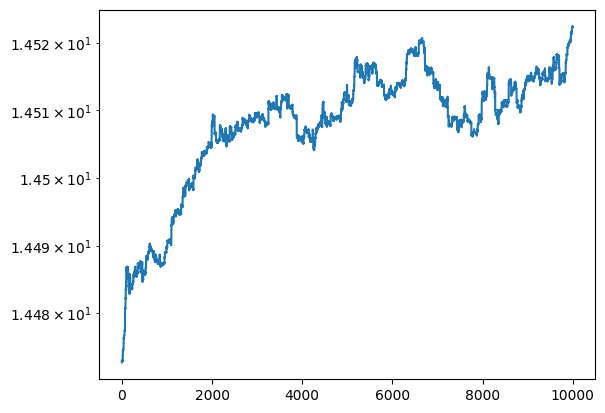

In [135]:
np.mean(data.trajectory.pressure, axis=0)

plt.plot((data.trajectory.ke_total + data.trajectory.pe_total)[:, 4])
# plt.plot(-data.trajectory.pressure)
plt.yscale('log')

In [8]:
dynamics_data_path = f"/home/mmccraw/dev/data/09-09-25/rigid-bumpy/test_dynamics"
data = load(dynamics_data_path, location=["final", "init"], load_trajectory=True, load_full=True)

In [9]:
desired_frames = 100
steps_to_animate = downsample(data, desired_frames)

# Define the output path
output_path = "test_rb.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=data,
    system_id=0,
    use_pbc=True,
    which='vertex',
    cmap_name='viridis'
)

Creating animation:   2%|▏         | 2/100 [00:00<00:08, 11.68it/s]

Saving animation to test_rb.gif...


Creating animation: 101it [00:17,  5.80it/s]                         

Animation saved successfully!


In [ ]:
import pydpmd as md
import numpy as np
import os
from system_building_resources import *
import time

data_path = "/home/mmccraw/dev/data/09-09-25/rigid-bumpy/test"
if not os.path.exists(data_path):
    os.makedirs(data_path)

radii = generate_bidisperse_radii(10, 0.5, 1.4)
which = 'small'
packing_fraction = 0.7
temperature = 1e-5
phi_increment = 1e-2
target_packing_fraction = 0.84


# mu_eff and nv can both either be scalar or list
# if list, must be of equal length and of same length as n_duplicates
n_duplicates = 10
mu_eff = [0.01, 0.05, 0.1, 0.5, 1.0, 0.01, 0.05, 0.1, 0.5, 1.0]
nv = [3, 3, 3, 3, 3, 6, 6, 6, 6, 6]
cap_nv = 3
add_core = True




import tempfile
import shutil
from pydpmd.utils import split_systems



Minimizing
Done


/home/mmccraw/dev/pydpmd/src/pydpmd/data/bumpy_utils.py:5: RuntimeWarning: invalid value encountered in sqrt
  return 1 / np.sqrt(((2 * vertex_radius) / ((outer_radius - vertex_radius) * np.sin(np.pi / num_vertices))) ** 2 - 1)
/home/mmccraw/dev/pydpmd/src/pydpmd/data/bumpy_utils.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(((2 * vertex_radius) / ((outer_radius - vertex_radius) * np.sin(np.pi / num_vertices))) ** 2 - 1)


In [214]:

rb.set_velocities(1e-3, 0)
rb.set_neighbor_method(NeighborMethod.Naive)
# rb.set_neighbor_method(NeighborMethod.Cell)
# set_standard_cell_list_parameters(rb, 0.3)
rb.save(os.path.abspath('test_data'))

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_rigid_bumpy_pbc_final"),
    os.path.abspath('test_data'),
    os.path.abspath('test_data'),
    str(1e4),
    str(1e0)
], check=True)

Running for 10000 steps
Step 0
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_rigid_bumpy_pbc_final', '/home/mmccraw/dev/analysis/fall-25/09/run/test_data', '/home/mmccraw/dev/analysis/fall-25/09/run/test_data', '10000.0', '1.0'], returncode=0)

In [216]:
rb = load(os.path.abspath('test_data'), location=["final", "init"], load_trajectory=True, load_full=True)

In [217]:
rb.init.packing_fraction

AttributeError: packing_fraction

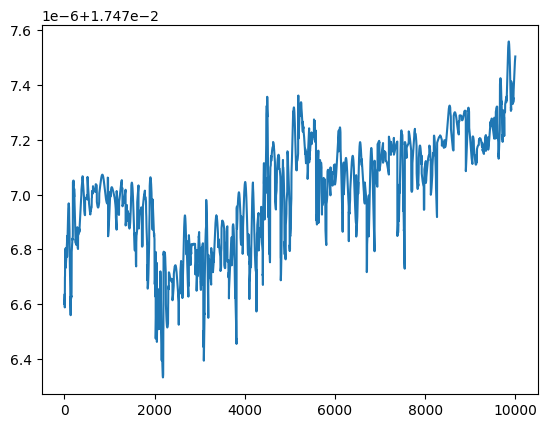

In [218]:
plt.plot((rb.trajectory.pe_total + rb.trajectory.ke_total)[:, 9])

In [219]:
from pydpmd.plot import draw_particles_frame, create_animation, downsample
desired_frames = 100
steps_to_animate = downsample(rb, desired_frames)

# Define the output path
output_path = "test_rb.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=rb,
    system_id=9,
    use_pbc=True,
    which='vertex',
    cmap_name='viridis'
)

Creating animation:   4%|▍         | 4/100 [00:00<00:03, 26.57it/s]

Saving animation to test_rb.gif...


Creating animation: 101it [00:05, 19.47it/s]                         

Animation saved successfully!


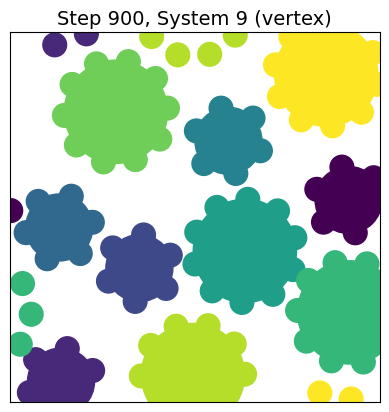

In [220]:
draw_particles_frame(900, plt.gca(), rb, 9, True, 'vertex', 'viridis', 'trajectory')

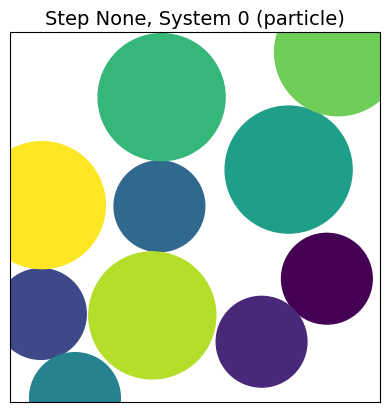

In [151]:
draw_particles_frame(None, plt.gca(), disks[9], 0, True, 'particle', 'viridis', None)